In [ ]:
!unzip maps.zip

In [4]:
from PIL import Image
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [5]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(".png") or f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path)
        width, height = image.size
        half_width = width // 2
        left_image = image.crop((0, 0, half_width, height))
        right_image = image.crop((half_width, 0, width, height))
        if self.transform:

            transformed = self.transform(image=np.array(left_image), image0=np.array(right_image))
            left_image, right_image = transformed['image'], transformed['image0']

        return left_image, right_image


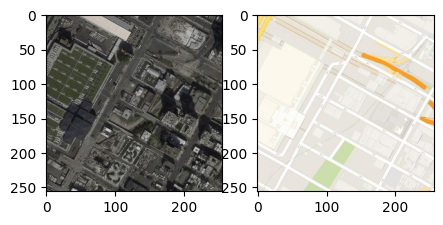

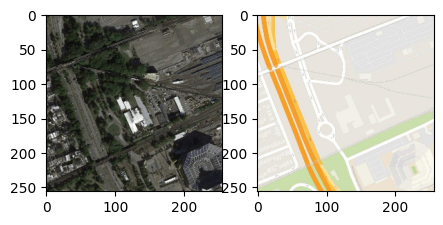

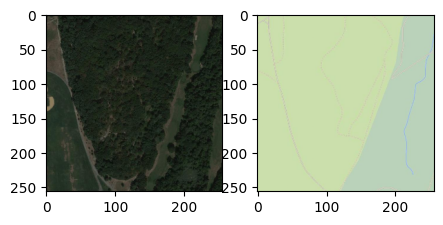

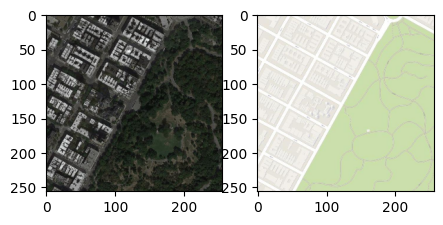

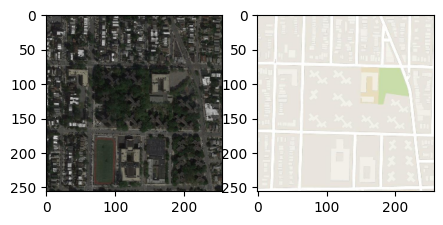

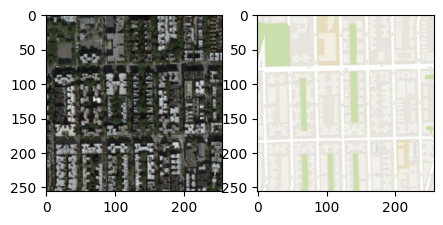

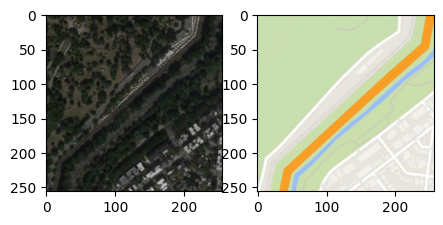

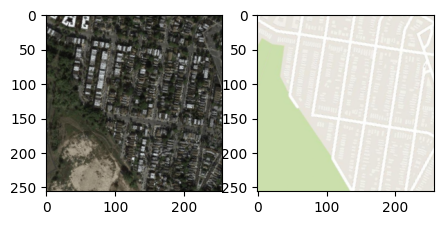

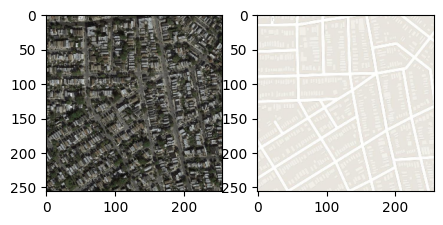

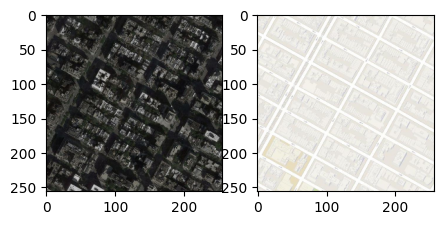

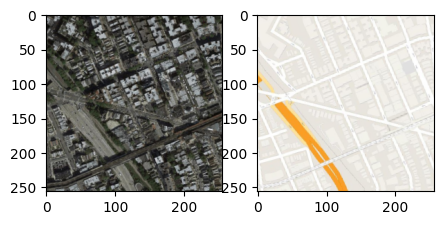

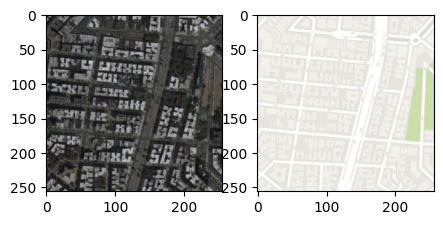

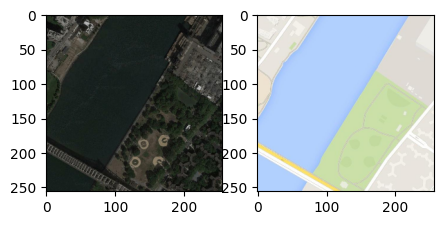

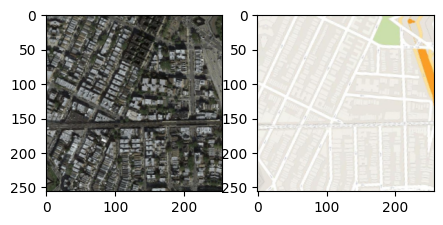

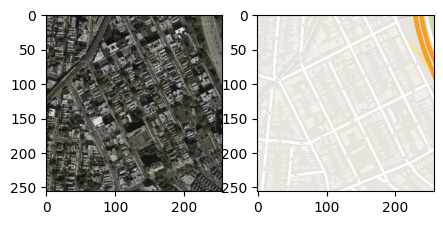

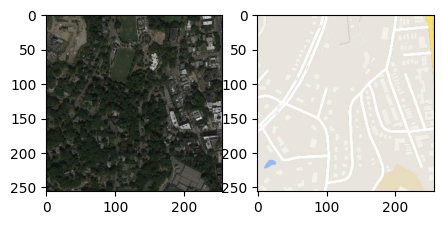

In [6]:
folder_path = '/content/maps/train'

# https://albumentations.ai/docs/api_reference/augmentations/
transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate(limit=40),
    A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5], max_pixel_value=255.0),
    ToTensorV2(),
], additional_targets = {'image0': 'image'})

train_dataset = CustomDataset(folder_path, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)

def show_images(left_image, right_image):

    for i, (left_img, right_img) in enumerate(zip(left_image, right_image)):
        fig = plt.figure(figsize=(5, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        left_img = left_img.permute(1, 2, 0)
        right_img = right_img.permute(1, 2, 0)
        ax1.imshow(left_img)
        ax2.imshow(right_img)


for images in train_dataloader:
    show_images(images[0]*0.5 + 0.5, images[1]*0.5+0.5)
    break


In [7]:
val_dataset = CustomDataset('/content/maps/val', transform=transform)

val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

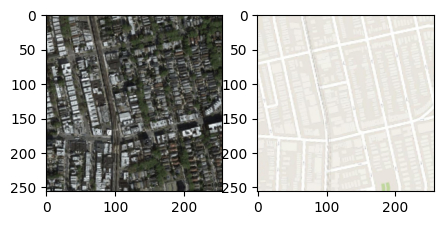

In [8]:
for images in val_dataloader:
    show_images(images[0]*0.5 + 0.5, images[1]*0.5+0.5)
    break

In [9]:
import torch
import torch.nn as nn

In [10]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, activation="relu", use_dropout=False, use_batchnorm = False, use_bias=False, kernel_size=4, stride=2, padding=1):
        super(Block, self).__init__()
        layers = []

        if downsample:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=use_bias, padding_mode='reflect'))
        else:
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=use_bias))

        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        if activation == "relu":
            layers.append(nn.ReLU())
        else:
            layers.append(nn.LeakyReLU(0.2))

        self.layers = nn.Sequential(*layers)
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layers(x)

        if self.use_dropout:
            x = self.dropout(x)
        return x



In [11]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, down_features=[3, 64, 128, 256, 512, 512, 512, 512, 512 ], up_features=[512,512,1024,512,1024,512, 1024, 512, 1024, 256, 512, 128, 256, 64]):#[512, 512, 512, 512, 512, 256, 128, 64]):
        super(Generator, self).__init__()

        down_layers = []

        for i, pair in enumerate([(down_features[i], down_features[i+1]) for i in range(len(down_features) - 1)]):
            down_layers.append(Block(pair[0], pair[1], use_dropout=False,downsample=True, activation="leaky" if i !=7 else "relu" , use_batchnorm= False if i == 0 or i == 7 else True))

        self.encoder = nn.Sequential(*down_layers)
        up_layers = []

        for i, pair in enumerate([(up_features[i], up_features[i+1]) for i in range(0,len(up_features) - 1,2)]): # co 1

            if i in [0,1,2]:
                up_layers.append(Block(pair[0], pair[1], use_dropout=True, use_batchnorm=True))
            else:
                up_layers.append(Block(pair[0], pair[1], use_dropout=False ,use_batchnorm = True))

        up_layers.append(nn.Sequential(
            nn.ConvTranspose2d(up_features[-1]*2,in_channels, kernel_size=4, stride=2, padding=1,), # up_features[-1]
            nn.Tanh(),
        ))
        self.decoder = nn.Sequential(*up_layers)


    def forward(self, x):
        encoder_outputs = []
        for layer in self.encoder:
            x = layer(x)
            encoder_outputs.append(x)

        x = self.decoder[0](x)
        
        for i in range(1,len(self.decoder)):
            # x = self.decoder[i](x) # this is used for encoder-decoder not unet
            x = self.decoder[i](torch.cat([x, encoder_outputs[-(i+1)]], 1))
        return x


Output is same size as the original picture so its good

In [12]:
x = torch.randn((1,3,256,256))
m = Generator()
preds = m(x)        
print(preds.shape) 

torch.Size([1, 3, 256, 256])


In [13]:
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True, use_bias=False, kernel_size=4, stride=2, padding=1):
        super().__init__()

        layers = []

        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=use_bias, padding_mode='reflect'))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))

        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64,128,256,512]):
        super().__init__()
        self.first_layer = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )

        layers = []
        for i, pair in enumerate([(features[i], features[i+1]) for i in range(len(features) - 1)]):
            layers.append(DiscBlock(pair[0], pair[1], stride = 1 if i==2 else 2))

        layers.append(nn.Sequential(
            nn.Conv2d(features[-1], 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'),
        ))

        self.layer = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        x = self.first_layer(x)

        return self.layer(x)


In [15]:
xD = torch.randn((1,3,256,256))
yD = torch.randn((1,3,256,256))
D = Discriminator()
predss = D(xD, yD)
print(predss.shape)

torch.Size([1, 1, 30, 30])


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
import torch.optim as optim
from tqdm import tqdm


In [17]:
import matplotlib.pyplot as plt

def plot_images(gen, loader):
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5

    fig, ax = plt.subplots(3, 1, figsize=(5, 15))

    x = x*0.5 + 0.5
    y = y*0.5 + 0.5
    
    ax[0].imshow(x.squeeze(0).permute(1, 2, 0).detach().cpu())
    ax[0].set_title("Input")
    ax[0].axis("off")
    
    ax[1].imshow(y.squeeze(0).permute(1, 2, 0).detach().cpu())
    ax[1].set_title("Real")
    ax[1].axis("off")

    ax[2].imshow(y_fake.squeeze(0).permute(1, 2, 0).detach().cpu())
    ax[2].set_title("Fake")
    ax[2].axis("off")

    plt.show()
    gen.train()


In [19]:
from IPython.display import clear_output

In [20]:
lr = 2e-4
G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

criterion_GAN = torch.nn.BCEWithLogitsLoss()
criterion_L1 = torch.nn.L1Loss()

In [ ]:
for epoch in range(200):
    loop = tqdm(train_dataloader)
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        fake_y = G(x)

        # GAN loss
        D_fake = D(x, fake_y)
        gan_loss = criterion_GAN(D_fake, torch.ones_like(D_fake))
        # L1 loss
        l1_loss = criterion_L1(fake_y, y)
        # Total loss
        G_loss = gan_loss + 100 * l1_loss
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()


        # Loss for real images
        D_real = D(x, y)
        real_loss = criterion_GAN(D_real, torch.ones_like(D_real))
        # Loss for fake images
        D_fake = D(x, fake_y.detach())
        fake_loss = criterion_GAN(D_fake, torch.zeros_like(D_fake))
        # Total loss
        D_loss = (real_loss + fake_loss) / 2
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()


        if idx % 10 == 0:
            loop.set_postfix(
                    epoch=epoch,
                    D_fake = fake_loss.mean().item(),
                    D_real_loss = real_loss.mean().item(),
                    G_loss = G_loss.mean().item(),
                    D_loss = D_loss.mean().item(),
                )
    if epoch % 5 ==0:
        plot_images(G, val_dataloader)


In [22]:
checkpoint_G = {
    "state_dict": G.state_dict(),
    "optimizer": G_optimizer.state_dict(),
}
torch.save(checkpoint_G, "G_checkpoint.pth.tar")

In [23]:
checkpoint_D = {
    "state_dict": D.state_dict(),
    "optimizer": D_optimizer.state_dict(),
}
torch.save(checkpoint_D, "D_checkpoint.pth.tar")

In [ ]:
for idx in range(50):
    plot_images(G, val_dataloader)